## Mounting GDrive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Setup system


In [2]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
from shapely.geometry import Point
from shapely.geometry import MultiPoint
from shapely.geometry import MultiPolygon
from shapely.geometry import Polygon
from shapely.geometry import box
from descartes.patch import PolygonPatch

import random
import pandas as pd
import scipy
import scipy.stats as st 
from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_pacf, pacf

import re

from shapely import geometry
import pickle
import time

from shapely import affinity
from shapely.geometry import LineString
import warnings

from itertools import cycle

warnings.simplefilter('ignore', np.RankWarning)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:

workingDir=os.getcwd()
workingDir=workingDir+"/drive/My Drive/"
#workingDir=workingDir+"/drive/My Drive/SYNC_Projects/"

print(workingDir)

uJDir=workingDir+"pHT/code/uJ/uJ_src_pHT/python"
sys.path.append(uJDir)


figuresDir=workingDir+"pHT/ms/figures/"

dataDir=workingDir+"pHT/"

from AnalysisFunctions import *
from PlottingFunctions import *


/content/drive/My Drive/
> Analysis Functions loaded
Importing readroi
DataStructs...loaded!
DataManagers...loaded!
PlottingFunctions... loaded!


## Auxiliary functions

In [0]:
def getDaughtersTrackIDs(trap_df_lineages, motherID):
  
    data_motherIDs=trap_df_lineages[0].motherID
    data_trackIDs=trap_df_lineages[0].trackID
    data_cellIDs=trap_df_lineages[0].cellID
    data_divisions=trap_df_lineages[0].division
    data_lineageIDs=trap_df_lineages[0].lineageID

    list_daughters=[]
    numDivisions=0
    for idata, this_division in enumerate(data_divisions):

        if this_division==1:
            if data_trackIDs.iloc[idata]==motherID:
                
                numDivisions=numDivisions+1

                #this is the mother
                mother_cellID=data_cellIDs.iloc[idata]
                mother_lineageID=data_lineageIDs.iloc[idata]
                mother_trackID=data_trackIDs.iloc[idata]

                daughter_trackID=data_trackIDs[data_motherIDs==mother_cellID].astype(str)
                if len(daughter_trackID)>0:
                    list_daughters.append(daughter_trackID.iloc[0])
            
    return set(list_daughters)
        

def getTimeSeries(trap_df_lineages, trackID, this_channel):
    all_trackIDs=trap_df_lineages[0].trackID
    data_frames=[]
    tseries=[]
    if True:
        for j, this_trackID in enumerate(all_trackIDs):
            
            
            if this_trackID==trackID:
                data_frames=trap_df_lineages[0].frame[trap_df_lineages[0].trackID==this_trackID]-frame_experiment_start+1
                data_division=trap_df_lineages[0].division[trap_df_lineages[0].trackID==this_trackID]
                frame_division=(data_frames[data_division.index[data_division == 1]]-frame_experiment_start)*frame2min
                
                if this_channel is 'length':
                    tseries=trap_df_lineages[0].length[trap_df_lineages[0].trackID==this_trackID]
                elif this_channel is 'GFP':
                    tseries=trap_df_lineages[0].GFP[trap_df_lineages[0].trackID==this_trackID]
                elif this_channel is 'DsRed':
                    tseries=trap_df_lineages[0].DsRed[trap_df_lineages[0].trackID==this_trackID]
                elif this_channel is 'RelInt':
                    tseries=trap_df_lineages[0].RelInt[trap_df_lineages[0].trackID==this_trackID]
                elif this_channel is 'AbsInt':
                    tseries=trap_df_lineages[0].AbsInt[trap_df_lineages[0].trackID==this_trackID]
                        
        return data_frames, tseries

def getDivisionTimeSeries(this_trap_df_lineages, this_trackID, this_channel, this_frame_experiment_start):
    tseries=[]
    if this_channel is 'length':
        tseries=this_trap_df_lineages[0].length[this_trap_df_lineages[0].trackID==this_trackID]
    elif this_channel is 'GFP':
        tseries=this_trap_df_lineages[0].GFP[this_trap_df_lineages[0].trackID==this_trackID]
    elif this_channel is 'DsRed':
        tseries=this_trap_df_lineages[0].DsRed[this_trap_df_lineages[0].trackID==this_trackID]
    elif this_channel is 'RelInt':
        tseries=this_trap_df_lineages[0].RelInt[this_trap_df_lineages[0].trackID==this_trackID]
    elif this_channel is 'AbsInt':
        tseries=this_trap_df_lineages[0].AbsInt[this_trap_df_lineages[0].trackID==this_trackID]

    data_frames=this_trap_df_lineages[0].frame[this_trap_df_lineages[0].trackID==this_trackID]+1
    data_division=this_trap_df_lineages[0].division[this_trap_df_lineages[0].trackID==this_trackID]
    frame0=data_division.index[data_division == 1].to_list()[0]
    frame_division=(data_frames[data_division.index[data_division == 1]])
    ret_division=frame_division*frame2min

    ret_series=tseries.iloc[data_division.index[data_division == 1]-frame0]

    return ret_division, ret_series
    
    

def unique(list1): 
    unique_list = [] 
    for x in list1: 
        if x not in unique_list: 
            unique_list.append(x) 
    return unique_list

# Load data

## HT-LB (Mother machine)

In [11]:

expeLabel="HT-LB"
rootDir=dataDir+"data/HT-LB/"
list_pos="xy03".split(",") 
frame2min=10.

frame_experiment_start=1
frame_experiment_end=865

dirNameROIs=rootDir+"data_rois/"
dirNameDATA=rootDir+'data/normData/'
dirNameCELLS=rootDir+'data_cells/'

trap_df_lineages=[]
for i,trap in enumerate(list_pos):
    print(trap)
    dirNameDATALINEAGES=rootDir+'data/lineages/'
    lineagesDataFile=dirNameDATALINEAGES+expeLabel+"_"+trap+"_lineages_all.csv"
    
    #print(lineagesDataFile)
    #df_lineages=load_data(lineagesDataFile)
    df_lineages=load_data_lineages(lineagesDataFile)
    list_frames=df_lineages.frame.unique()
    trap_df_lineages.append(df_lineages)

xy03
Loading 168 lineages from /content/drive/My Drive/pHT/data/HT-LB/data/lineages/HT-LB_xy03_lineages_all.csv


## HT-CAZ (Microchemostat)

In [6]:


CAZ_expeLabel="HT-CAZ"
CAZ_rootDir=dataDir+"data/HT-CAZ/"
CAZ_list_pos="xy34".split(",") 
CAZ_frame2min=10.

CAZ_frame_experiment_start=55
CAZ_frame_experiment_end=127

CAZ_dirNameROIs=rootDir+"data_rois/"
CAZ_dirNameDATA=rootDir+'data/normData/'
CAZ_dirNameCELLS=rootDir+'data_cells/'

CAZ_trap_df_lineages=[]
for i,trap in enumerate(CAZ_list_pos):
    print(trap)
    dirNameDATALINEAGES=CAZ_rootDir+'data/lineages/'
    lineagesDataFile=dirNameDATALINEAGES+CAZ_expeLabel+"_"+trap+"_lineages_long.csv"
    
    #print(lineagesDataFile)
    #df_lineages=load_data(lineagesDataFile)
    CAZ_df_lineages=load_data_lineages(lineagesDataFile)
    CAZ_list_frames=CAZ_df_lineages.frame.unique()
    CAZ_trap_df_lineages.append(CAZ_df_lineages)

CAZ_trap_df_lineages_all=[]
for i,trap in enumerate(CAZ_list_pos):
    print(trap)
    dirNameDATALINEAGES=CAZ_rootDir+'data/lineages/'
    lineagesDataFile=dirNameDATALINEAGES+CAZ_expeLabel+"_"+trap+"_lineages_all.csv"
    
    #print(lineagesDataFile)
    #df_lineages=load_data(lineagesDataFile)
    CAZ_df_lineages=load_data_lineages(lineagesDataFile)
    CAZ_list_frames=CAZ_df_lineages.frame.unique()
    CAZ_trap_df_lineages_all.append(CAZ_df_lineages)



xy34
Loading 43 lineages from /content/drive/My Drive/pHT/data/HT-CAZ/data/lineages/HT-CAZ_xy34_lineages_long.csv
xy34
Loading 557 lineages from /content/drive/My Drive/pHT/data/HT-CAZ/data/lineages/HT-CAZ_xy34_lineages_all.csv


## HT-AMP (Microchemostat)

In [7]:

AMP_expeLabel="HT-AMP"
AMP_rootDir=dataDir+"data/HT-AMP/"
AMP_list_pos="xy15".split(",") 
AMP_frame2min=10.

AMP_frame_experiment_start=55
AMP_frame_experiment_end=127

AMP_dirNameROIs=rootDir+"data_rois/"
AMP_dirNameDATA=rootDir+'data/normData/'
AMP_dirNameCELLS=rootDir+'data_cells/'

AMP_trap_df_lineages=[]
for i,trap in enumerate(AMP_list_pos):
    print(trap)
    dirNameDATALINEAGES=AMP_rootDir+'data/lineages/'
    lineagesDataFile=dirNameDATALINEAGES+AMP_expeLabel+"_"+trap+"_lineages_long.csv"
    
    #print(lineagesDataFile)
    #df_lineages=load_data(lineagesDataFile)
    AMP_df_lineages=load_data_lineages(lineagesDataFile)
    AMP_list_frames=AMP_df_lineages.frame.unique()
    AMP_trap_df_lineages.append(AMP_df_lineages)
AMP_trap_df_lineages_all=[]
for i,trap in enumerate(AMP_list_pos):
    print(trap)
    dirNameDATALINEAGES=AMP_rootDir+'data/lineages/'
    lineagesDataFile=dirNameDATALINEAGES+AMP_expeLabel+"_"+trap+"_lineages_all.csv"
    
    #print(lineagesDataFile)
    #df_lineages=load_data(lineagesDataFile)
    AMP_df_lineages=load_data_lineages(lineagesDataFile)
    AMP_list_frames=AMP_df_lineages.frame.unique()
    AMP_trap_df_lineages_all.append(AMP_df_lineages)

xy15
Loading 35 lineages from /content/drive/My Drive/pHT/data/HT-AMP/data/lineages/HT-AMP_xy15_lineages_long.csv
xy15
Loading 498 lineages from /content/drive/My Drive/pHT/data/HT-AMP/data/lineages/HT-AMP_xy15_lineages_all.csv


## Statistics 

In [8]:

gfp_dist=get_gfps(trap_df_lineages, list_pos, 20.)
dsred_dist=get_dsreds(trap_df_lineages, list_pos, 20.)
length_dist=get_lengths(trap_df_lineages, list_pos, 20.)

print('%s @time=0'%expeLabel)
print('numCells =',len(length_dist))
print('mean(length) =',np.mean(length_dist))
print('std(length) =',np.std(length_dist))
#y_sos=np.mean(length_dist)+2*np.std(length_dist)


print('min(GFP) =',np.min(gfp_dist))
print('max(GFP) =',np.max(gfp_dist))
print('mean(GFP) =',np.mean(gfp_dist))
print('std(GFP) =',np.std(gfp_dist))


print('min(DsRed) =',np.min(dsred_dist))
print('max(DsRed) =',np.max(dsred_dist))
print('mean(DsRed) =',np.mean(dsred_dist))
print('std(DsRed) =',np.std(dsred_dist))

HT-LB @time=0
numCells = 182
mean(length) = 24.633491030880638
std(length) = 6.345124021020169
min(GFP) = 106.602
max(GFP) = 424.323
mean(GFP) = 219.7129395604396
std(GFP) = 59.139635790571134
min(DsRed) = 120.744
max(DsRed) = 502.691
mean(DsRed) = 153.81045604395607
std(DsRed) = 39.50592984834218


### Divisions

In [15]:
this_channel='RelInt' #['length','GFP','DsRed','RelInt','AbsInt']
print("LB")
sel_trackIDs=['1.166-865.009','1.159-865.002','1.161-865.000','1.162-865.006','1.165-865.044']
lb_n_divisions=[]
for this_trackID in sel_trackIDs:
    try:
        lb_division_times, val_relInt=getDivisionTimeSeries(trap_df_lineages, this_trackID, this_channel, frame_experiment_start)
        if len(division_times)>2:
            lb_n_divisions.append(len(lb_division_times))          
            print("",this_trackID,": ",len(lb_division_times),"divisions")
    except:
        continue
print("Average division:%s\t%s "%(round(np.mean(lb_n_divisions)),lb_n_divisions))

print("CAZ")
caz_trackIDs=CAZ_trap_df_lineages[0].trackID.unique()
caz_n_divisions=[]
for this_trackID in caz_trackIDs:
    try:
        caz_division_times, val_relInt=getDivisionTimeSeries(CAZ_trap_df_lineages, this_trackID, this_channel, frame_experiment_start)
        if len(division_times)>2:
            caz_n_divisions.append(len(caz_division_times))          
            print("",this_trackID,": ",len(caz_division_times),"divisions", len(val_relInt))
    except:
        continue
print("Number of lineages: ",len(CAZ_trap_df_lineages_all[0].lineageID.unique()))
print("Number of tracks: ",len(CAZ_trap_df_lineages_all[0].trackID.unique()))
print("Average divisions per long tracks:%s\t%s "%(round(np.mean(caz_n_divisions)),len(caz_trackIDs)))

print("AMP")
amp_trackIDs=AMP_trap_df_lineages[0].trackID.unique()
amp_n_divisions=[]
for this_trackID in amp_trackIDs:
    try:
        amp_division_times, val_relInt=getDivisionTimeSeries(AMP_trap_df_lineages, this_trackID, this_channel, frame_experiment_start)
        if len(division_times)>2:
            amp_n_divisions.append(len(amp_division_times))          
            #print("",this_trackID,": ",len(amp_division_times),"divisions")
    except:
        continue

print("Number of lineages: ",len(AMP_trap_df_lineages_all[0].lineageID.unique()))
print("Number of tracks: ",len(AMP_trap_df_lineages_all[0].trackID.unique()))

print("Average division per long tracks :%s\t number of cells %s "%(round(np.mean(amp_n_divisions)),len(amp_trackIDs)))


#amp_division_times, val_relInt=getDivisionTimeSeries(AMP_trap_df_lineages, this_trackID, this_channel, frame_experiment_start)




LB
Average division:nan	[] 
CAZ


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number of lineages:  557
Number of tracks:  5870
Average divisions per long tracks:nan	48 
AMP
Number of lineages:  498
Number of tracks:  5754
Average division per long tracks :nan	 number of cells 46 


## Plot time-series of selected cells

1.159-865.002 : 73 divisions
1.161-865.000 : 99 divisions
1.162-865.006 : 83 divisions
1.165-865.044 : 49 divisions
1.166-865.009 : 79 divisions
Saving /content/drive/My Drive/pHT/ms/figures/figure3_xy03_RelInt_1.169-865.028.pdf


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


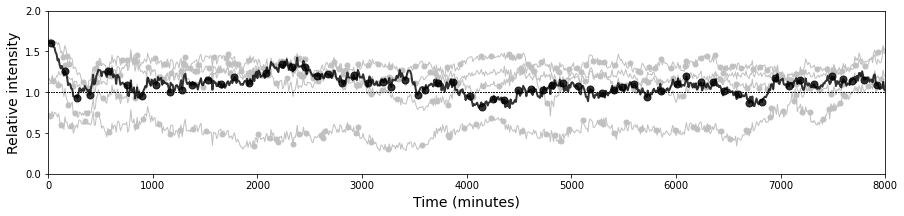

In [13]:

def plotTimeSeries(trap_df_lineages, trackIDs, channels):
    fig=plt.figure(figsize=(15,3))
    ax = plt.axes()
    
    minT=frame_experiment_start*frame2min
    maxT=frame_experiment_end*frame2min
    cycol = cycle('bgrcmk')


    for i,trap in enumerate(list_pos):

        t0_lineages=pd.unique(trap_df_lineages[i].trackID[trap_df_lineages[i].frame==frame_experiment_start])
        t11_lineages=pd.unique(trap_df_lineages[i].trackID[trap_df_lineages[i].frame==frame_experiment_end])

        trap_lineages=np.intersect1d(t11_lineages,t0_lineages)
        for j, this_lineage in enumerate(trap_lineages):
            #print(this_lineage)
            if this_lineage in trackIDs:
                
                #this_color=next(cycol)
                #print(this_lineage)
                if this_lineage == '1.166-865.009':
                    this_color='k'
                    this_alpha=.8
                    this_width=2
                    this_markersize=7
                else:
                    this_color='silver'
                    this_alpha=1
                    this_width=1
                    this_markersize=5
                
                data_frames=trap_df_lineages[i].frame[trap_df_lineages[i].trackID==this_lineage]-frame_experiment_start+1
                data_division=trap_df_lineages[i].division[trap_df_lineages[i].trackID==this_lineage]
                frame_division=(data_frames[data_division.index[data_division == 1]]-frame_experiment_start)*frame2min
                
                print(this_lineage,':', len(frame_division),'divisions')
                
                for this_channel in channels:
                
                    if this_channel is 'length':
                        data_lengths=trap_df_lineages[i].length[trap_df_lineages[i].trackID==this_lineage]
                        ax.plot(data_frames*frame2min-frame_experiment_start, data_lengths, color=this_color, alpha=this_alpha, linewidth=this_width)
                        
                        ax.set_ylabel('Cell length (px)', fontname="Arial")
                    elif this_channel is 'GFP':
                        data_gfps=trap_df_lineages[i].GFP[trap_df_lineages[i].trackID==this_lineage]
                        ax.plot((data_frames-frame_experiment_start)*frame2min, data_gfps, color=this_color, alpha=1, linewidth=1)
                    
                        ax.plot(frame_division, data_gfps[data_gfps.index[data_division == 1]], 'o', color=this_color, alpha=this_alpha, linewidth=this_width)
                 
                    
                    elif this_channel is 'DsRed':
                        data_dsreds=trap_df_lineages[i].DsRed[trap_df_lineages[i].trackID==this_lineage]
                        ax.plot((data_frames-frame_experiment_start)*frame2min, data_dsreds, color=this_color, alpha=1, linewidth=1)
                    
                        ax.plot(frame_division, data_dsreds[data_dsreds.index[data_division == 1]], 'o', color=this_color, alpha=this_alpha, linewidth=this_width)
                 
                    
                    elif this_channel is 'RelInt':
                        data_relint=trap_df_lineages[i].RelInt[trap_df_lineages[i].trackID==this_lineage]
                        ax.plot((data_frames-frame_experiment_start)*frame2min, data_relint, color=this_color, alpha=this_alpha, linewidth=this_width)
                        ax.plot((data_frames-frame_experiment_start)*frame2min, np.ones(len(data_frames)), color='k', linestyle=':', alpha=this_alpha, linewidth=1)
                        
                        ax.set_ylabel('Relative intensity', fontname="Arial", fontsize=14)
                        ax.set_ylim([0, 2])
                        
                        ax.plot(frame_division, data_relint[data_relint.index[data_division == 1]], 'o', color=this_color, alpha=this_alpha, linewidth=this_width, markersize=this_markersize)
                 
                    elif this_channel is 'AbsInt':
                        data_absint=trap_df_lineages[i].AbsInt[trap_df_lineages[i].trackID==this_lineage]
                        ax.plot((data_frames-frame_experiment_start)*frame2min, data_absint, color=this_color, alpha=1, linewidth=1)
                        ax.set_ylabel('GFP (a.u.)', fontname="Arial")
                        
                        ax.plot(frame_division, data_absint[data_absint.index[data_division == 1]], 'o', color=this_color, alpha=this_alpha, linewidth=this_width, markersize=this_markersize)
                 
                    ax.set_xlabel('Time (minutes)', fontname="Arial", fontsize=14)
                    ax.set_xlim([0., 8000.])
                    
                    mpl.rcParams.update({'font.size': 12})
                    
    fileName=figuresDir+'figure3_'+trap+'_'+this_channel+'_'+this_lineage+'.pdf'
    print('Saving '+fileName)
    plt.savefig(fileName)

sel_channels=['RelInt'] #['length','GFP','DsRed','RelInt','AbsInt']
#sel_trackIDs=['1.166-865.009']
sel_trackIDs=['1.166-865.009','1.159-865.002','1.161-865.000','1.162-865.006','1.165-865.044']
plotTimeSeries(trap_df_lineages, sel_trackIDs, sel_channels)

plt.show()





## Recover relative intensity (at the moment of division) of selected lineages

In [10]:

this_channel='RelInt' #['length','GFP','DsRed','RelInt','AbsInt']
sel_trackIDs=['1.166-865.009','1.159-865.002','1.161-865.000','1.162-865.006','1.165-865.044']

delta_relInt=[]
for this_trackID in sel_trackIDs:
    try:
        division_times, val_relInt=getDivisionTimeSeries(trap_df_lineages, this_trackID, this_channel, frame_experiment_start)
        if len(division_times)>2:
            delta_relInt.extend(np.diff(val_relInt).tolist())
            print("",this_trackID,": ",len(division_times),"divisions")
    except:
        continue


 1.166-865.009 :  79 divisions
 1.159-865.002 :  73 divisions
 1.161-865.000 :  99 divisions
 1.162-865.006 :  83 divisions
 1.165-865.044 :  49 divisions


## Plot distribution of $\Delta$ Rel Int

mu= 0.0005742930799089589
sigma= 0.09601324109492236
Saving /content/drive/My Drive/pHT/ms/figures/figure3_PDF_deltaRelInt.pdf


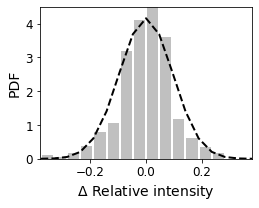

In [0]:
fig=plt.figure(figsize=(3.8,2.8))
n, bins, patches = plt.hist(x=delta_relInt, bins=18, color='silver', alpha=1, rwidth=0.85, density=1)

(mu, sigma) = norm.fit(delta_relInt)
y = norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'k--', linewidth=2)

print("mu=",mu)
print("sigma=",sigma)

plt.xlabel('$\Delta$ Relative intensity', fontsize=14)
plt.ylabel('PDF', fontsize=14)
maxfreq = n.max()
plt.ylim(ymax=4.5)
plt.xlim(xmin=-0.38, xmax=0.38)

mpl.rcParams.update({'font.size': 12})

fileName=figuresDir+'figure3_PDF_deltaRelInt.pdf'
print('Saving '+fileName)
plt.savefig(fileName)

plt.show()


## Plot $\Delta$ Relative intensity as a function of time (divisions)


Saving /content/drive/My Drive/pHT/ms/figures/figure3_time_deltaRelInt.pdf


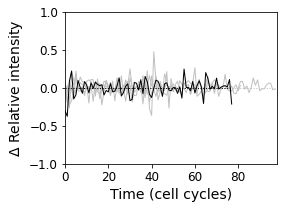

In [0]:
fig=plt.figure(figsize=(3.8,2.8))
ax = plt.axes()


sel_trackIDs=['1.159-865.002','1.161-865.000','1.162-865.006','1.165-865.044','1.166-865.009']
,
for this_trackID in sel_trackIDs:
    try:
        x_data,y_data=getDivisionTimeSeries(trap_df_lineages, this_trackID, this_channel, frame_experiment_start)
        y_data_diff=np.diff(y_data)
        
        if this_trackID == '1.166-865.009':
            this_col='k'
        else:
            this_col='silver'
        
        ax.plot(np.arange(len(y_data_diff)), y_data_diff,'-', color=this_col, alpha=1, linewidth=1)
        ax.plot(np.arange(len(y_data_diff)), np.zeros(len(y_data_diff)), ':',color=this_col, alpha=1, linewidth=1)
        ax.set_ylabel('$\Delta$ Relative intensity', fontsize=14)
        ax.set_xlabel('Time (cell cycles)', fontsize=14)
        ax.set_ylim([-1, 1])
        ax.set_xlim([0, 98])
    except:
        continue
    
mpl.rcParams.update({'font.size': 12})

fileName=figuresDir+'figure3_time_deltaRelInt.pdf'
print('Saving '+fileName)
plt.savefig(fileName)

plt.show()

## Plot Partial autocorrelation function

Saving /content/drive/My Drive/pHT/ms/figures/figure3_pacf_relInt.pdf


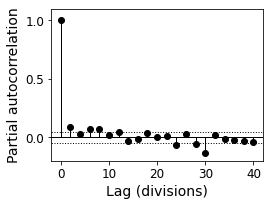

In [0]:


y_data_all=[]
this_channel='RelInt' #['length','GFP','DsRed','RelInt','AbsInt']

sel_trackIDs=['1.166-865.009','1.159-865.002','1.161-865.000','1.162-865.006','1.165-865.044']
#sel_trackIDs=unique(trap_df_lineages[0].trackID)
for this_trackID in sel_trackIDs:

        
    x_data,y_data=getDivisionTimeSeries(trap_df_lineages, this_trackID, this_channel,frame_experiment_start)

    y_data_all.extend(y_data)


y_series = pd.Series(y_data_all)        
        
fig=plt.figure(figsize=(3.8,2.8))
ax = plt.axes()

y_pacf=pacf(y_series, 40, 'ywunbiased') 
nstep=2
ax.plot(np.arange(0, len(y_pacf),nstep), y_pacf[0::nstep],'o', color='k', alpha=1, linewidth=1)
for ip in np.arange(0, len(y_pacf),nstep):
    ax.plot([ip, ip], [0, y_pacf[ip]], color='k', alpha=1, linewidth=1)
ax.plot([-3, 43], [.05, .05],':', color='k', alpha=1, linewidth=1)
ax.plot([-3, 43], [-.05, -.05],':', color='k', alpha=1, linewidth=1)
ax.plot([-3, 43], [0,0],'-', color='k', alpha=1, linewidth=1)
ax.plot(np.arange(len(y_pacf)), np.zeros(len(y_pacf)),':', color='k', alpha=1, linewidth=1)
ax.set_ylabel('Partial autocorrelation', fontsize=14)
ax.set_xlabel('Lag (divisions)', fontsize=14)        
ax.set_ylim(ymin=-0.2, ymax=1.1)     
ax.set_yticks([0, .5, 1.])
ax.set_xlim(xmin=-2, xmax=42)
    
mpl.rcParams.update({'font.size': 12})

fileName=figuresDir+'figure3_pacf_relInt.pdf'
print('Saving '+fileName)
plt.savefig(fileName)

plt.show()


## Estimate $\Delta$ Relative intensity for LB+CAZ

In [0]:
CAZ_sel_trackIDs=CAZ_df_lineages.trackID.unique()

this_channel='RelInt' 

CAZ_delta_relInt=[]
for this_trackID in CAZ_sel_trackIDs:
    try:
        division_times, val_relInt=getDivisionTimeSeries(CAZ_trap_df_lineages, this_trackID, this_channel, frame_experiment_start)
        if len(division_times)>2:
            CAZ_delta_relInt.extend(np.diff(val_relInt).tolist())
            print("",this_trackID,": ",len(division_times),"divisions")
    except:
        continue

 55.241-127.000 :  13 divisions
 55.268-127.001 :  22 divisions
 55.263-127.002 :  13 divisions
 55.244-127.003 :  12 divisions
 55.246-127.005 :  15 divisions
 55.312-127.008 :  11 divisions
 63.273-127.266 :  14 divisions
 55.288-127.009 :  13 divisions
 55.277-127.010 :  13 divisions
 59.264-127.028 :  11 divisions
 55.254-127.011 :  11 divisions
 55.261-127.012 :  11 divisions
 59.251-127.013 :  12 divisions
 55.230-127.018 :  16 divisions
 55.194-127.019 :  8 divisions
 55.287-127.022 :  13 divisions
 55.170-127.023 :  7 divisions
 55.238-127.024 :  15 divisions
 64.211-127.143 :  10 divisions
 55.288-127.032 :  13 divisions
 55.185-127.033 :  18 divisions
 55.315-127.034 :  4 divisions
 55.103-127.036 :  15 divisions
 55.247-127.043 :  12 divisions
 55.221-127.060 :  13 divisions
 55.233-127.064 :  12 divisions
 55.279-127.069 :  10 divisions
 55.332-127.070 :  12 divisions
 55.318-127.071 :  5 divisions
 55.270-127.078 :  11 divisions
 55.245-127.079 :  13 divisions
 55.252-127.

## Estimate $\Delta$ Relative intensity for LB+AMP

In [0]:
AMP_sel_trackIDs=AMP_df_lineages.trackID.unique()

this_channel='RelInt' 

AMP_delta_relInt=[]
for this_trackID in AMP_sel_trackIDs:
    #print('trackID: ',this_trackID)
    try:
        division_times, val_relInt=getDivisionTimeSeries(AMP_trap_df_lineages, this_trackID, this_channel, AMP_frame_experiment_start)
        #print('division_times: ',division_times.to_list())
        if len(division_times)>2:
            AMP_delta_relInt.extend(np.diff(val_relInt[val_relInt>0]).tolist())
            print("",this_trackID,": ",len(division_times),"divisions")
    except Exception as e: 
        print("Error",e)
        continue


 55.242-127.000 :  18 divisions
 55.318-127.001 :  14 divisions
 67.297-125.231 :  13 divisions
 55.324-127.003 :  15 divisions
 56.309-127.035 :  13 divisions
 55.322-127.004 :  22 divisions
 62.316-121.052 :  15 divisions
 55.307-127.005 :  19 divisions
 59.300-119.119 :  7 divisions
 55.274-127.006 :  25 divisions
 71.242-127.044 :  20 divisions
 55.331-127.008 :  19 divisions
 55.305-127.010 :  18 divisions
 65.310-127.013 :  18 divisions
 55.128-127.011 :  20 divisions
 55.393-127.015 :  20 divisions
 55.340-127.017 :  19 divisions
 55.020-127.020 :  10 divisions
 55.365-127.024 :  14 divisions
 64.384-127.117 :  16 divisions
 55.376-127.028 :  23 divisions
 61.364-117.305 :  15 divisions
 55.153-127.031 :  18 divisions
 55.230-127.048 :  25 divisions
 55.351-127.121 :  19 divisions
 55.250-127.122 :  24 divisions
 55.303-127.139 :  12 divisions
 55.384-127.144 :  17 divisions
 58.432-127.165 :  23 divisions
 55.327-127.145 :  11 divisions
 55.321-127.146 :  26 divisions
 55.192-1

## Plot $\Delta$ Relative intensity for all environmental conditions (LB, CAZ and AMP)

0.38597377313659537
Saving /content/drive/My Drive/pHT/ms/figures/figure3_boxplot_deltaRelInt.pdf


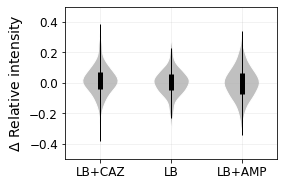

In [0]:
fig=plt.figure(figsize=(3.8,2.8))
ax = plt.axes()

inds=[1,2,3]

#ax.plot([0,4],[0,0],'k-', linewidth=1)

CAZ_parts=ax.violinplot(CAZ_delta_relInt,showmeans=False, showmedians=False,showextrema=False, positions=[1])
CAZ_quartile1, CAZ_medians, CAZ_quartile3, CAZ_range = np.percentile(CAZ_delta_relInt, [25, 50, 75, 99])
print(CAZ_range)
ax.vlines(1, -CAZ_range, CAZ_range, color='k', linestyle='-', lw=1)
ax.vlines(1, CAZ_quartile1, CAZ_quartile3, color='k', linestyle='-', lw=5)
for pc in CAZ_parts['bodies']:
    pc.set_facecolor('silver')
    pc.set_edgecolor('white')
    pc.set_alpha(1)

parts=ax.violinplot(delta_relInt,showmeans=False, showmedians=False,showextrema=False, positions=[2])
quartile1, medians, quartile3, LB_range = np.percentile(delta_relInt, [25, 50, 75,99])
ax.vlines(2, -LB_range, LB_range, color='k', linestyle='-', lw=1)
ax.vlines(2, quartile1, quartile3, color='k', linestyle='-', lw=5)
for pc in parts['bodies']:
    pc.set_facecolor('silver')
    pc.set_edgecolor('white')
    pc.set_alpha(1)

AMP_parts=ax.violinplot(AMP_delta_relInt,showmeans=False, showmedians=False,showextrema=False, positions=[3])
AMP_quartile1, AMP_medians, AMP_quartile3, AMP_range = np.percentile(AMP_delta_relInt, [25, 50, 75, 99])
ax.vlines(3, -AMP_range, AMP_range, color='k', linestyle='-', lw=1)
ax.vlines(3, AMP_quartile1, AMP_quartile3, color='k', linestyle='-', lw=5)
for pc in AMP_parts['bodies']:
    pc.set_facecolor('silver')
    pc.set_edgecolor('white')
    pc.set_alpha(1)

ax.grid(alpha=0.2)
plt.setp(ax, xticks=inds,xticklabels=['LB+CAZ', 'LB', 'LB+AMP'])

    

plt.ylabel('$\Delta$ Relative intensity', fontsize=14)

plt.ylim(ymin=-.5, ymax=.5)
plt.xlim(xmin=.5, xmax=3.5)


mpl.rcParams.update({'font.size': 12})

fileName=figuresDir+'figure3_boxplot_deltaRelInt.pdf'
print('Saving '+fileName)
plt.savefig(fileName)


plt.show()


### Normality test
#### If p-value >alpha (0.05), the distributions are identical



LB
mu:0.0005742930799089589 sd:0.09601324109492236 var:0.009218542465551687
Moments: DescribeResult(nobs=378, minmax=(-0.37638929069595417, 0.4720062035947393), mean=0.0005742930799089589, variance=0.00924299483283432, skewness=-0.15406268679676885, kurtosis=2.602347209039853)
Ks_2sampResult(statistic=0.23095238095238096, pvalue=0.5272204326508804)
AMP
mu:-0.0007337900221543924 sd:0.11346304143582517 var:0.012873861771867778
Moments: DescribeResult(nobs=744, minmax=(-0.4637251197355856, 0.45513195538866946), mean=-0.0007337900221543924, variance=0.01289118863831713, skewness=0.20780758985269338, kurtosis=1.5011039106634039)
Ks_2sampResult(statistic=0.2357142857142857, pvalue=0.4933090953221133)
CAZ
mu:0.012980668484035344 sd:0.09902897286312597 var:0.00980673746632574
Moments: DescribeResult(nobs=495, minmax=(-0.4331432317784052, 0.38646800034903483), mean=0.012980668484035344, variance=0.009826589161601701, skewness=0.0059676251922527014, kurtosis=2.037043576862981)
Ks_2sampResult(sta

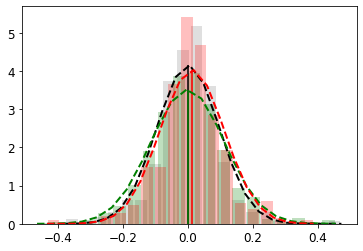

In [0]:
nbins=20
print("LB")
#max_delta=.5 
max_delta=2

nl, bins, patches = plt.hist(x=delta_relInt, bins=nbins, color='gray', alpha=.25, rwidth=0.85, density=1)
(mu, sigma) = norm.fit(delta_relInt)
print("mu:%s sd:%s var:%s"%(mu, sigma,sigma**2))
print("Moments:", st.describe(delta_relInt))
yl = norm.pdf( bins, mu, sigma)
plt.plot(bins, yl, 'k--', linewidth=2)
plt.vlines(x=mu,ymin=0,ymax=np.max(yl))
delta_lims=plt.xlim()
max_delta=max(-delta_lims[0],delta_lims[1])
#max_delta=2
res=st.ks_2samp(yl,nl)
print(res)

print("AMP")
AMP_delta_relInt_=[x for x in AMP_delta_relInt if abs(x)<max_delta]
na, bins, patches = plt.hist(x=AMP_delta_relInt_, bins=nbins, color='green', alpha=.25, rwidth=0.85, density=1)
(mu, sigma) = norm.fit(AMP_delta_relInt_)
print("mu:%s sd:%s var:%s"%(mu, sigma,sigma**2))
print("Moments:", st.describe(AMP_delta_relInt_))
ya = norm.pdf( bins, mu, sigma)
plt.plot(bins, ya, 'g--', linewidth=2)
plt.vlines(x=mu,ymin=0,ymax=np.max(ya),color='green')
res=st.ks_2samp(ya,na)
print(res)

print("CAZ")
CAZ_delta_relInt_=[x for x in CAZ_delta_relInt if abs(x)<max_delta]
nc, bins, patches = plt.hist(x=CAZ_delta_relInt_, bins=nbins, color='red', alpha=.25, rwidth=0.85, density=1)
(mu, sigma) = norm.fit(CAZ_delta_relInt_)
print("mu:%s sd:%s var:%s"%(mu, sigma,sigma**2))
print("Moments:", st.describe(CAZ_delta_relInt_))
yc = norm.pdf( bins, mu, sigma)
plt.plot(bins, yc, 'r--', linewidth=2)
plt.vlines(x=mu,ymin=0,ymax=np.max(yc),color='red')
res=st.ks_2samp(yc,nc)
print(res)

plt.show()